In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
train = pd.read_csv("sign_mnist_train.csv")
test = pd.read_csv("sign_mnist_test.csv")
target_names = ["a","b","c","d","e","f","g","h","i","k","l","m","n","o","p",
    "q","r","s","t","u","v","w","x","y"]
target_names = list(target_names)

print(train.shape)

labels = train['label'].values
labels_arr = np.array(labels)
print(len(np.unique(labels_arr)))

train.drop('label', axis=1, inplace=True)

images = train.values

images = np.array([np.reshape(i, (28,28)) for i in images])
images = np.array([i.flatten() for i in images])

labels = LabelBinarizer().fit_transform(labels)
images = images.astype("float")/255.0
images = images.reshape(images.shape[0], 28, 28, 1)


X_train, X_val, y_train, y_val= train_test_split(images, labels, test_size = 0.3)

(27455, 785)
24


In [8]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the input shape
input_shape = (28, 28, 1)

# Define the ResNet model
inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# Define the residual blocks
def residual_block(x, filters, strides=1):
    identity = x
    x = layers.Conv2D(filters, (3, 3), strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    if strides != 1 or identity.shape[-1] != filters:
        identity = layers.Conv2D(filters, (1, 1), strides=strides)(identity)
        identity = layers.BatchNormalization()(identity)
    x = layers.Add()([x, identity])
    x = layers.Activation('relu')(x)
    return x

x = residual_block(x, 64)
x = residual_block(x, 64)
x = residual_block(x, 128, strides=2)
x = residual_block(x, 128)
x = residual_block(x, 256, strides=2)
x = residual_block(x, 256)
x = residual_block(x, 512, strides=2)
x = residual_block(x, 512)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(24, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 14, 14, 64)   3200        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_20 (BatchN  (None, 14, 14, 64)  256         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_17 (Activation)     (None, 14, 14, 64)   0           ['batch_normalization_20[0]

                                                                  'activation_23[0][0]']          
                                                                                                  
 activation_25 (Activation)     (None, 4, 4, 128)    0           ['add_11[0][0]']                 
                                                                                                  
 conv2d_30 (Conv2D)             (None, 2, 2, 256)    295168      ['activation_25[0][0]']          
                                                                                                  
 batch_normalization_30 (BatchN  (None, 2, 2, 256)   1024        ['conv2d_30[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_26 (Activation)     (None, 2, 2, 256)    0           ['batch_normalization_30[0][0]'] 
          

 obalAveragePooling2D)                                                                            
                                                                                                  
 dense_1 (Dense)                (None, 24)           12312       ['global_average_pooling2d_1[0][0
                                                                 ]']                              
                                                                                                  
Total params: 11,196,952
Trainable params: 11,187,352
Non-trainable params: 9,600
__________________________________________________________________________________________________


In [9]:
import time
start_time = time.time()
model=model.fit(X_train,y_train,validation_data=(X_val, y_val), batch_size=32, epochs=5, verbose=1)
print(f'\nDuration: {time.time() - start_time:.0f} seconds')


Epoch 1/5
601/601 [==============================] - 369s 604ms/step - loss: 0.4903 - accuracy: 0.8526 - val_loss: 0.9886 - val_accuracy: 0.6723
Epoch 2/5
601/601 [==============================] - 359s 597ms/step - loss: 0.0741 - accuracy: 0.9761 - val_loss: 1.1507 - val_accuracy: 0.6740
Epoch 3/5
601/601 [==============================] - 356s 593ms/step - loss: 0.0749 - accuracy: 0.9775 - val_loss: 0.7042 - val_accuracy: 0.8163
Epoch 4/5
601/601 [==============================] - 354s 589ms/step - loss: 0.0494 - accuracy: 0.9854 - val_loss: 1.2433 - val_accuracy: 0.7334
Epoch 5/5
601/601 [==============================] - 360s 599ms/step - loss: 0.0222 - accuracy: 0.9933 - val_loss: 1.1184e-04 - val_accuracy: 1.0000

Duration: 1797 seconds


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


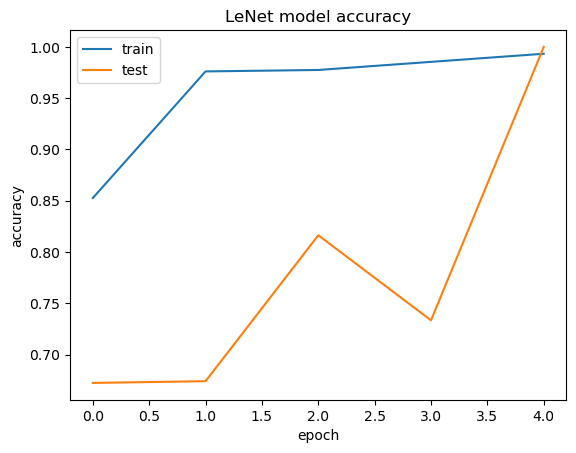

In [10]:
import matplotlib.pyplot as plt
import numpy as np
print(model.history.keys())
# summarize history for accuracy
plt.plot(model.history['accuracy'])
plt.plot(model.history['val_accuracy'])
plt.title('ResNet model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

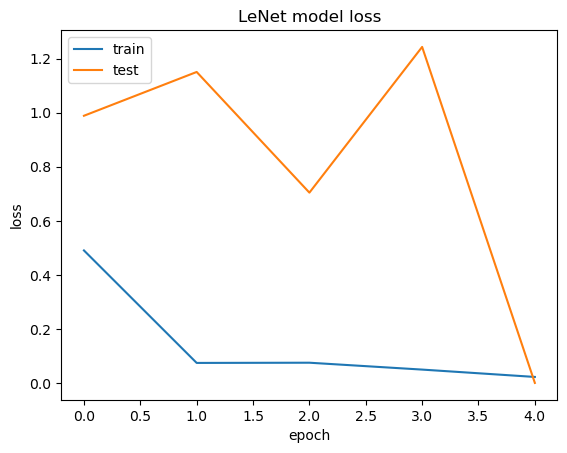

In [11]:
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('ResNet model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()